In [1]:
import os
import re

import numpy as np
import pandas as pd

# Text analysis
import gensim
from gensim import corpora
import nltk
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')

import spacy

# Visualization
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_colwidth", 200)
pyLDAvis.enable_notebook()

%matplotlib inline

[nltk_data] Downloading package wordnet to /home/ajmc/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# function to plot most frequent terms
def freq_words(x, terms = 30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()

    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

    # selecting top n most frequent words
    d = words_df.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set(ylabel = 'Count')
    plt.show()
    
    return d
    

In [3]:
DATASETS_FOLDER = "datasets"
ABSTRACTS_FOLDER = "abstracts"

ABSTRACTS_FOLDER_PATH = f"{DATASETS_FOLDER}/{ABSTRACTS_FOLDER}/"

In [4]:
with open(f"../{DATASETS_FOLDER}/abstracts_with_last_citation.csv", 'r') as f:
    df = pd.read_csv(f)

df['text'] = df['title'] + ' ' + df['description']
df['text'] = df['text'].apply(lambda x: x.replace('\n', ' '))

df['date'] = df['date'].astype('datetime64[ns]')
# df['date_from'] = df['date_from'].astype('datetime64[ns]')
df['last_citation'] = df['last_citation'].astype('datetime64[ns]')

In [5]:
df.head()

,paper,emails,description,date,from,title,authors,comments,subj-class,journal-ref,last_citation,text
0,1001,['psa@math.duke.edu'],These are notes based on lectures given at TASI99. We review the geometry of\nthe moduli space of N=2 theories in four dimensions from the point of view of\nsuperstring compactification. The cases...,2000-01-01,Paul S. Aspinwall <psa@math.duke.edu>,"Compactification, Geometry and Duality: N=2",Paul S. Aspinwall,"82 pages, 8 figures, LaTeX2e, TASI99, refs added and some typos fixed",NaN,NaN,2002-12-18,"Compactification, Geometry and Duality: N=2 These are notes based on lectures given at TASI99. We review the geometry of the moduli space of N=2 theories in four dimensions from the point of view ..."
1,1002,['pope@absinthe.physics.tamu.edu'],"We point out that massive gauged supergravity potentials, for example those\narising due to the massive breathing mode of sphere reductions in M-theory or\nstring theory, allow for supersymmetric ...",2000-01-03,Chris Pope <pope@absinthe.physics.tamu.edu>,Domain Walls and Massive Gauged Supergravity Potentials,"M. Cvetic, H. Lu and C.N. Pope","latex file, 11 pages, 3 figures",NaN,Class.Quant.Grav. 17 (2000) 4867-4876,2001-06-05,"Domain Walls and Massive Gauged Supergravity Potentials We point out that massive gauged supergravity potentials, for example those arising due to the massive breathing mode of sphere reductions i..."
2,1003,['kang@physics.inje.ac.kr'],"Recently, Ivanov and Volovich (hep-th/9912242) claimed that the perturbation\nof $h_{\mu\nu}$ with nonvanishing transverse components $h_{5\mu}$ is not\nlocalized on the brane because $h_{\mu\nu}$...",2000-01-01,KANG Gungwon <kang@physics.inje.ac.kr>,"Comment on ""Metric Fluctuations in Brane Worlds""",Y.S. Myung and Gungwon Kang,"4 pages, revtex",NaN,NaN,2001-07-09,"Comment on ""Metric Fluctuations in Brane Worlds"" Recently, Ivanov and Volovich (hep-th/9912242) claimed that the perturbation of $h_{\mu\nu}$ with nonvanishing transverse components $h_{5\mu}$ is ..."
3,1004,['adam@godel.math.missouri.edu'],"Quantum fields responding to ""moving mirrors"" have been predicted to give\nrise to thermodynamic paradoxes. I show that the assumption in such work that\nthe mirror can be treated as an external f...",2000-01-01,Adam D. Helfer <adam@godel.math.missouri.edu>,Moving Mirrors and Thermodynamic Paradoxes,Adam D. Helfer,"7 pages, Revtex with Latex2e",NaN,Phys.Rev. D63 (2001) 025016,2000-01-07,"Moving Mirrors and Thermodynamic Paradoxes Quantum fields responding to ""moving mirrors"" have been predicted to give rise to thermodynamic paradoxes. I show that the assumption in such work that t..."
4,1005,['jfuchs@mail.desy.de'],"Various aspects of spaces of chiral blocks are discussed. In particular,\nconjectures about the dimensions of irreducible sub-bundles are reviewed and\ntheir relation to symmetry breaking conforma...",2000-01-02,Juergen Fuchs <jfuchs@mail.desy.de>,Bundles of chiral blocks and boundary conditions in CFT,"J. Fuchs, C. Schweigert","18 pages, LaTeX2e; slightly extended version of contribution to the",NaN,NaN,2000-11-13,"Bundles of chiral blocks and boundary conditions in CFT Various aspects of spaces of chiral blocks are discussed. In particular, conjectures about the dimensions of irreducible sub-bundles are rev..."


In [23]:
with open(f"../{DATASETS_FOLDER}/nodes_with_all_network_stats_and_timestamps.csv", 'r') as f:
    nodes_with_stats = pd.read_csv(f)

nodes_communities = nodes_with_stats[['Id', 'modularity_class']]
nodes_communities.columns = ['Id', 'community']
    
df_with_communities = df.merge(nodes_communities, how="outer", left_on = 'paper', right_on = 'Id')
df_with_communities.head()

,paper,emails,description,date,from,title,authors,comments,subj-class,journal-ref,last_citation,text,Id,community
0,1001,['psa@math.duke.edu'],These are notes based on lectures given at TASI99. We review the geometry of\nthe moduli space of N=2 theories in four dimensions from the point of view of\nsuperstring compactification. The cases...,2000-01-01,Paul S. Aspinwall <psa@math.duke.edu>,"Compactification, Geometry and Duality: N=2",Paul S. Aspinwall,"82 pages, 8 figures, LaTeX2e, TASI99, refs added and some typos fixed",NaN,NaN,2002-12-18,"Compactification, Geometry and Duality: N=2 These are notes based on lectures given at TASI99. We review the geometry of the moduli space of N=2 theories in four dimensions from the point of view ...",1001.0,42.0
1,1002,['pope@absinthe.physics.tamu.edu'],"We point out that massive gauged supergravity potentials, for example those\narising due to the massive breathing mode of sphere reductions in M-theory or\nstring theory, allow for supersymmetric ...",2000-01-03,Chris Pope <pope@absinthe.physics.tamu.edu>,Domain Walls and Massive Gauged Supergravity Potentials,"M. Cvetic, H. Lu and C.N. Pope","latex file, 11 pages, 3 figures",NaN,Class.Quant.Grav. 17 (2000) 4867-4876,2001-06-05,"Domain Walls and Massive Gauged Supergravity Potentials We point out that massive gauged supergravity potentials, for example those arising due to the massive breathing mode of sphere reductions i...",1002.0,29.0
2,1003,['kang@physics.inje.ac.kr'],"Recently, Ivanov and Volovich (hep-th/9912242) claimed that the perturbation\nof $h_{\mu\nu}$ with nonvanishing transverse components $h_{5\mu}$ is not\nlocalized on the brane because $h_{\mu\nu}$...",2000-01-01,KANG Gungwon <kang@physics.inje.ac.kr>,"Comment on ""Metric Fluctuations in Brane Worlds""",Y.S. Myung and Gungwon Kang,"4 pages, revtex",NaN,NaN,2001-07-09,"Comment on ""Metric Fluctuations in Brane Worlds"" Recently, Ivanov and Volovich (hep-th/9912242) claimed that the perturbation of $h_{\mu\nu}$ with nonvanishing transverse components $h_{5\mu}$ is ...",1003.0,29.0
3,1004,['adam@godel.math.missouri.edu'],"Quantum fields responding to ""moving mirrors"" have been predicted to give\nrise to thermodynamic paradoxes. I show that the assumption in such work that\nthe mirror can be treated as an external f...",2000-01-01,Adam D. Helfer <adam@godel.math.missouri.edu>,Moving Mirrors and Thermodynamic Paradoxes,Adam D. Helfer,"7 pages, Revtex with Latex2e",NaN,Phys.Rev. D63 (2001) 025016,2000-01-07,"Moving Mirrors and Thermodynamic Paradoxes Quantum fields responding to ""moving mirrors"" have been predicted to give rise to thermodynamic paradoxes. I show that the assumption in such work that t...",1004.0,2.0
4,1005,['jfuchs@mail.desy.de'],"Various aspects of spaces of chiral blocks are discussed. In particular,\nconjectures about the dimensions of irreducible sub-bundles are reviewed and\ntheir relation to symmetry breaking conforma...",2000-01-02,Juergen Fuchs <jfuchs@mail.desy.de>,Bundles of chiral blocks and boundary conditions in CFT,"J. Fuchs, C. Schweigert","18 pages, LaTeX2e; slightly extended version of contribution to the",NaN,NaN,2000-11-13,"Bundles of chiral blocks and boundary conditions in CFT Various aspects of spaces of chiral blocks are discussed. In particular, conjectures about the dimensions of irreducible sub-bundles are rev...",1005.0,0.0


In [19]:
# Initialising NLTK components
stop_words = stopwords.words('english')
stop_words.append('the')

# NLTK Stemming and Lemmatizer
stemmer = SnowballStemmer("english", ignore_stopwords=True)
wordnet_lemmatizer = WordNetLemmatizer()

In [20]:
# Text processing functions

# function to remove stopwords
def remove_stopwords(rev):
    rev_new = " ".join([i for i in rev if i not in stop_words])
    return rev_new

def preprocess_texts(texts):
    papers_text = []
    
    for t in texts:
        pt = []

        # Using spacy lemmatisation
        # doc = nlp(t) 
        # papers_text.append(" ".join([token.lemma_ for token in doc if len(token) > 2]))

        for w in t.split():
            if len(w) > 2:
                # Using stemming
                # pt.append(stemmer.stem(w))
                # Using lemmatisation
                pt.append(wordnet_lemmatizer.lemmatize(w))
        papers_text.append(" ".join(pt))

    # make entire text lowercase
    texts_lower = [r.lower() for r in papers_text]

    # remove stopwords from the text
    output = [remove_stopwords(r.split()) for r in texts_lower]
    
    return output

In [26]:
communities = [29, 1, 42, 31]

Total papers to process 3020 in community 29


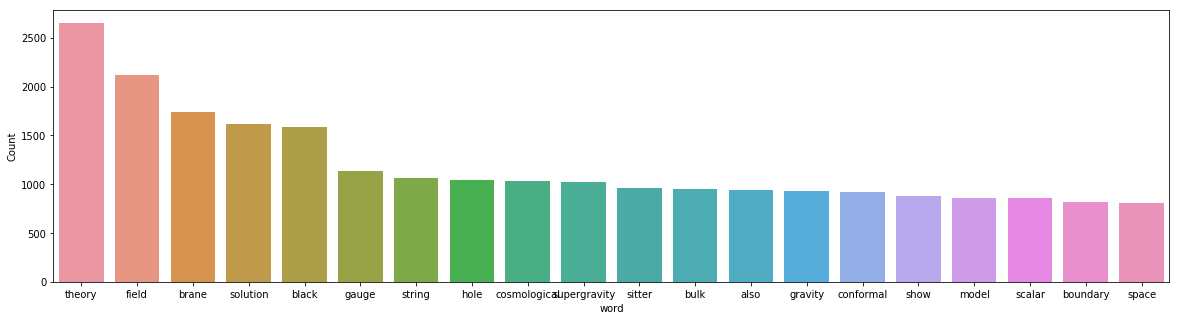

Most frequent words:               word  count
102        theory   2651
273         field   2114
80          brane   1742
22       solution   1620
705         black   1582
592         gauge   1139
16         string   1066
706          hole   1041
733  cosmological   1035
4    supergravity   1022
32         sitter    964
560          bulk    951
66           also    936
35        gravity    933
287     conformal    921
235          show    877
156         model    859
57         scalar    856
50       boundary    814
226         space    806
Sample of tokenised text:  ['domain', 'walls', 'massive', 'gauged', 'supergravity', 'potentials', 'point', 'massive', 'gauged', 'supergravity', 'potentials,', 'example', 'arising', 'due', 'massive', 'breathing', 'mode', 'sphere', 'reduction', 'm-theory', 'string', 'theory,', 'allow', 'supersymmetric', '(static)', 'domain', 'wall', 'solution', 'hybrid', 'randall-sundrum', 'domain', 'wall', 'one', 'side,', 'dilatonic', 'domain', 'wall', 'run-away', 'd

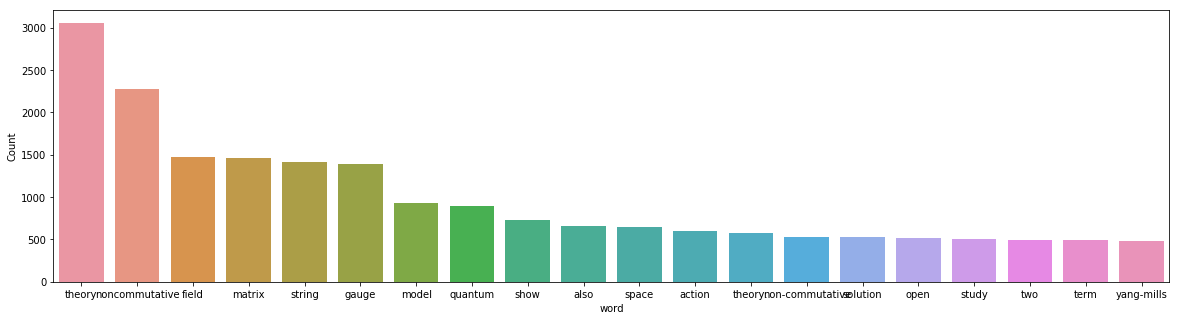

Most frequent words:                  word  count
41            theory   3055
15    noncommutative   2280
30             field   1469
71            matrix   1459
240           string   1412
124            gauge   1391
101            model    932
192          quantum    899
55              show    730
63              also    656
148            space    642
95            action    594
77           theory.    574
147  non-commutative    531
344         solution    523
239             open    522
217            study    507
256              two    499
39              term    488
40        yang-mills    485
Sample of tokenised text:  ['noncommutativities', 'd-branes', '$\\theta$-changing', 'degrees', 'freedom', 'known', 'several', 'd-branes,', 'space-time', 'coordinate', 'general', 'become', 'noncommutative.', 'point', 'view', 'noncommutative', 'geometry,', 'reflects', 'noncommutativity', 'world', 'volume', 'd-branes.', 'hand,', 'showed', 'previous', 'work,', 'presence', 'constant', 'antisy

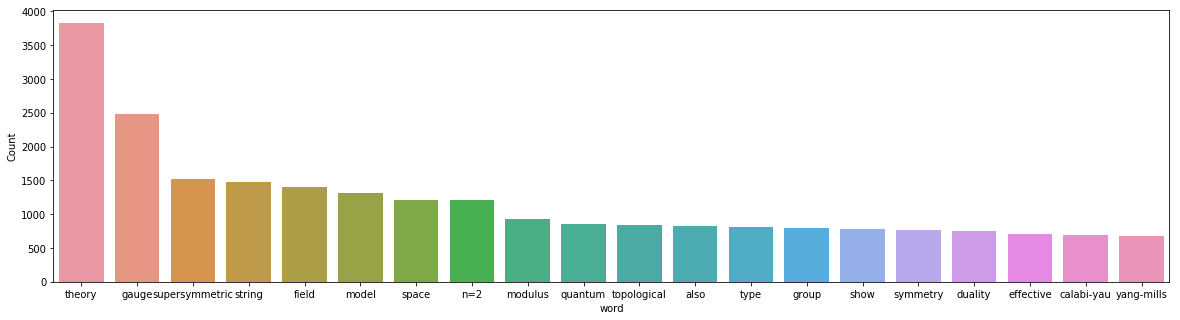

Most frequent words:                 word  count
12           theory   3828
155           gauge   2485
152  supersymmetric   1525
23           string   1472
216           field   1407
227           model   1320
11            space   1215
3               n=2   1213
10          modulus    936
58          quantum    852
785     topological    847
136            also    830
20             type    807
181           group    798
114            show    784
159        symmetry    769
108         duality    755
573       effective    702
25       calabi-yau    694
421      yang-mills    680
Sample of tokenised text:  ['compactification,', 'geometry', 'duality:', 'n=2', 'note', 'based', 'lecture', 'given', 'tasi99.', 'review', 'geometry', 'modulus', 'space', 'n=2', 'theory', 'four', 'dimension', 'point', 'view', 'superstring', 'compactification.', 'case', 'type', 'iia', 'type', 'iib', 'string', 'compactified', 'calabi-yau', 'threefold', 'heterotic', 'string', 'compactified', 'k3xt2', 'considered

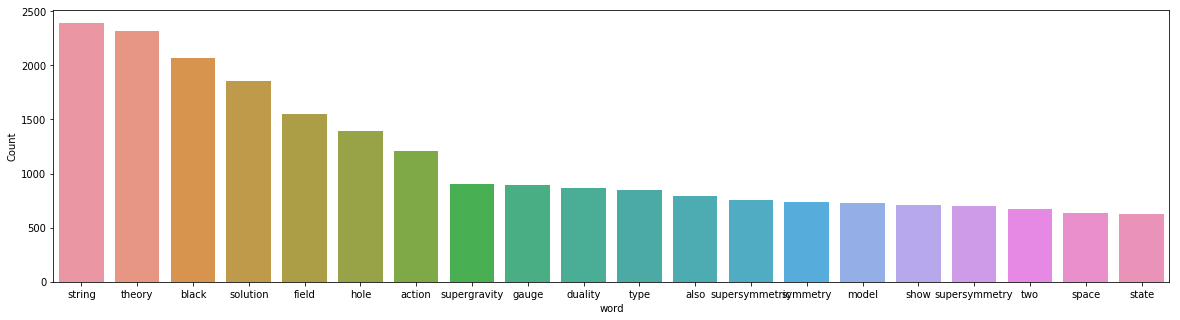

Most frequent words:                 word  count
115          string   2391
80           theory   2319
238           black   2071
88         solution   1852
305           field   1548
239            hole   1389
16           action   1212
518    supergravity    900
117           gauge    891
75          duality    865
352            type    849
70             also    797
17   supersymmetric    756
501        symmetry    738
53            model    727
35             show    708
2     supersymmetry    698
59              two    675
11            space    637
21            state    630
Sample of tokenised text:  ['instantons,', 'euclidean', 'supersymmetry', 'wick', 'rotation', 'discus', 'reality', 'property', 'fermionic', 'collective', 'coordinate', 'euclidean', 'space', 'instanton', 'background', 'construct', 'hermitean', 'action', 'supersymmetric', 'euclidean', 'yang-mills', 'theories.'] ['bps', 'state', 'd=4', 'n=1', 'supersymmetry', 'find', 'combination', 'momentum', 'domain-wall', 'ch

In [27]:
for community in communities:
    papers_in_communities = df_with_communities[community == df_with_communities['community']]

    print(f'Total papers to process {papers_in_communities.shape[0]} in community {community}')

    text_in_community = list(papers_in_communities.text)
    texts = preprocess_texts(text_in_community)
    
    print("Most frequent words: ", freq_words(texts, 20))

    tokenized_text = [x.split() for x in texts]
    print("Sample of tokenised text: ", tokenized_text[0], tokenized_text[1])

    dictionary = corpora.Dictionary(tokenized_text)
    doc_term_matrix = [dictionary.doc2bow(rev) for rev in tokenized_text]

    # Creating the object for LDA model using gensim library
    LDA = gensim.models.ldamodel.LdaModel

    # Build LDA model
    lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=3, random_state=100,
                    chunksize=1000, passes=10)

    print('LDA topics: ', lda_model.print_topics())

    # Prepare visualisation and output results
    vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)
    
    output_lda_visualisation_file = f'lda_community_{community}.html'
    pyLDAvis.save_html(vis, output_lda_visualisation_file)
    
    print(f'Saved output LDA visualisation in {output_lda_visualisation_file}')

    print('========================')